# Named Entity Recognition (NER) on Twitter Data

## Problem Statement
Twitter processes ~6,000 tweets/second (500 million/day). This project builds NER models to automatically identify named entities in tweets without relying on hashtags.

**10 NER Categories:** person, geo-location, company, facility, product, music artist, movie, sports team, tv show, other

In [ ]:
# Install required packages
!pip install tensorflow==2.15 transformers datasets seqeval gensim scikit-learn matplotlib seaborn pandas -q

In [19]:
!pip install tensorflow-cpu==2.16.1 -q
!pip install tf-keras==2.16.0 --no-dependencies -q

In [ ]:
!pip install "numpy<2" 

  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plaidml-keras 0.7.0 requires keras==2.2.4, but you have keras 3.10.0 which is incompatible.
qiskit-machine-learning 0.8.4 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

print("Libraries imported successfully!")

## 1. Data Loading & Understanding CoNLL Format

In [2]:
def load_conll_data(filepath):
    """Load CoNLL format data where each line has: word\ttag"""
    sentences, labels = [], []
    current_sentence, current_labels = [], []
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line == '':
                if current_sentence:
                    sentences.append(current_sentence)
                    labels.append(current_labels)
                    current_sentence, current_labels = [], []
            else:
                parts = line.split('\t')
                if len(parts) == 2:
                    current_sentence.append(parts[0])
                    current_labels.append(parts[1])
    
    if current_sentence:
        sentences.append(current_sentence)
        labels.append(current_labels)
    
    return sentences, labels

# Load data
train_sentences, train_labels = load_conll_data('data/wnut 16.txt.conll')
test_sentences, test_labels = load_conll_data('data/wnut 16test.txt.conll')

print(f"Training sentences: {len(train_sentences)}")
print(f"Test sentences: {len(test_sentences)}")
print(f"\nSample sentence: {train_sentences[1]}")
print(f"Sample labels: {train_labels[1]}")

Training sentences: 2394
Test sentences: 3850

Sample sentence: ['Made', 'it', 'back', 'home', 'to', 'GA', '.', 'It', 'sucks', 'not', 'to', 'be', 'at', 'Disney', 'world', ',', 'but', 'its', 'good', 'to', 'be', 'home', '.', 'Time', 'to', 'start', 'planning', 'the', 'next', 'Disney', 'World', 'trip', '.']
Sample labels: ['O', 'O', 'O', 'O', 'O', 'B-geo-loc', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-facility', 'I-facility', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-facility', 'I-facility', 'O', 'O']


## 2. Exploratory Data Analysis

In [3]:
# Flatten labels and count
all_train_labels = [label for seq in train_labels for label in seq]
label_counts = Counter(all_train_labels)

# Get unique tags
unique_tags = sorted(set(all_train_labels))
print(f"Unique tags ({len(unique_tags)}): {unique_tags}")

# Create tag mappings
tag2idx = {tag: idx for idx, tag in enumerate(unique_tags)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}
print(f"\nTag to Index mapping: {tag2idx}")

Unique tags (21): ['B-company', 'B-facility', 'B-geo-loc', 'B-movie', 'B-musicartist', 'B-other', 'B-person', 'B-product', 'B-sportsteam', 'B-tvshow', 'I-company', 'I-facility', 'I-geo-loc', 'I-movie', 'I-musicartist', 'I-other', 'I-person', 'I-product', 'I-sportsteam', 'I-tvshow', 'O']

Tag to Index mapping: {'B-company': 0, 'B-facility': 1, 'B-geo-loc': 2, 'B-movie': 3, 'B-musicartist': 4, 'B-other': 5, 'B-person': 6, 'B-product': 7, 'B-sportsteam': 8, 'B-tvshow': 9, 'I-company': 10, 'I-facility': 11, 'I-geo-loc': 12, 'I-movie': 13, 'I-musicartist': 14, 'I-other': 15, 'I-person': 16, 'I-product': 17, 'I-sportsteam': 18, 'I-tvshow': 19, 'O': 20}


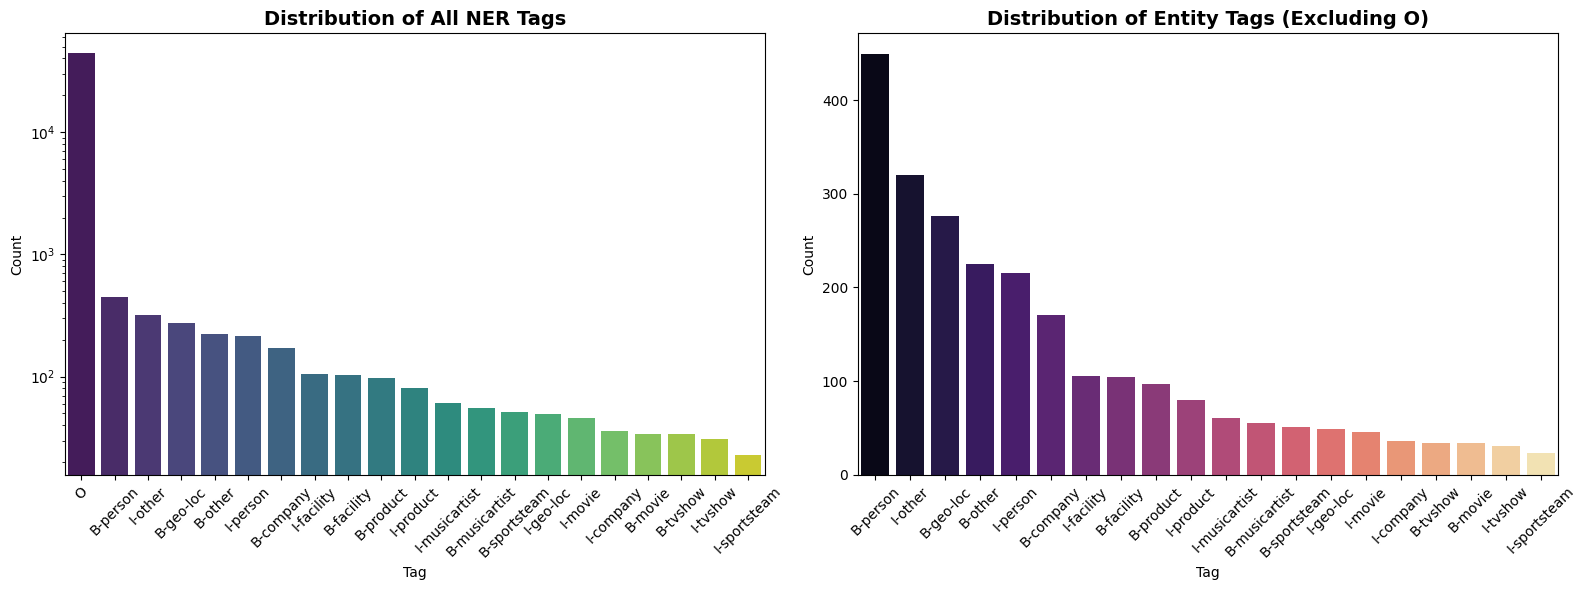


O tag percentage: 94.70%


In [4]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All labels
labels_df = pd.DataFrame(label_counts.items(), columns=['Tag', 'Count']).sort_values('Count', ascending=False)
sns.barplot(data=labels_df, x='Tag', y='Count', ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of All NER Tags', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_yscale('log')

# Entity labels only (excluding 'O')
entity_counts = {k: v for k, v in label_counts.items() if k != 'O'}
entity_df = pd.DataFrame(entity_counts.items(), columns=['Tag', 'Count']).sort_values('Count', ascending=False)
sns.barplot(data=entity_df, x='Tag', y='Count', ax=axes[1], palette='magma')
axes[1].set_title('Distribution of Entity Tags (Excluding O)', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nO tag percentage: {label_counts['O']/sum(label_counts.values())*100:.2f}%")

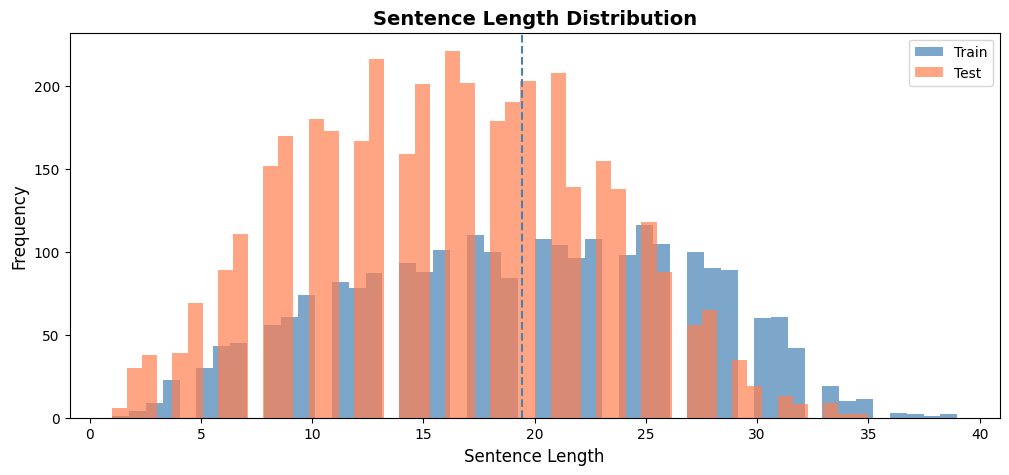

Train - Mean: 19.4, Max: 39, Min: 1
Test - Mean: 16.1, Max: 35, Min: 1


In [5]:
# Sentence length distribution
train_lengths = [len(s) for s in train_sentences]
test_lengths = [len(s) for s in test_sentences]

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(train_lengths, bins=50, alpha=0.7, label='Train', color='steelblue')
ax.hist(test_lengths, bins=50, alpha=0.7, label='Test', color='coral')
ax.set_xlabel('Sentence Length', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Sentence Length Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.axvline(np.mean(train_lengths), color='steelblue', linestyle='--', label=f'Train Mean: {np.mean(train_lengths):.1f}')
plt.show()

print(f"Train - Mean: {np.mean(train_lengths):.1f}, Max: {max(train_lengths)}, Min: {min(train_lengths)}")
print(f"Test - Mean: {np.mean(test_lengths):.1f}, Max: {max(test_lengths)}, Min: {min(test_lengths)}")

## 3. Data Preprocessing

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

print(f"TensorFlow version: {tf.__version__}")

# Parameters
MAX_LEN = 50
EMBEDDING_DIM = 100

# Build word vocabulary
all_words = [word for sentence in train_sentences for word in sentence]
word_counts = Counter(all_words)
vocab = ['<PAD>', '<UNK>'] + [word for word, count in word_counts.most_common()]
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

print(f"Vocabulary size: {len(vocab)}")
print(f"Number of tags: {len(unique_tags)}")

TensorFlow version: 2.16.1
Vocabulary size: 10588
Number of tags: 21


In [7]:
def encode_sequences(sentences, labels, word2idx, tag2idx, max_len):
    """Encode sentences and labels to numerical sequences"""
    X = [[word2idx.get(word, word2idx['<UNK>']) for word in sent] for sent in sentences]
    y = [[tag2idx[tag] for tag in label_seq] for label_seq in labels]
    
    X = pad_sequences(X, maxlen=max_len, padding='post', value=word2idx['<PAD>'])
    y = pad_sequences(y, maxlen=max_len, padding='post', value=tag2idx['O'])
    
    return X, y

# Encode data
X_train_full, y_train_full = encode_sequences(train_sentences, train_labels, word2idx, tag2idx, MAX_LEN)
X_test, y_test = encode_sequences(test_sentences, test_labels, word2idx, tag2idx, MAX_LEN)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1915, 50), y_train shape: (1915, 50)
X_val shape: (479, 50), y_val shape: (479, 50)
X_test shape: (3850, 50), y_test shape: (3850, 50)


## 4. Word2Vec Embeddings

In [10]:
from gensim.models import Word2Vec

# Train Word2Vec
w2v_model = Word2Vec(sentences=train_sentences, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4, epochs=10)

# Create embedding matrix
embedding_matrix = np.zeros((len(vocab), EMBEDDING_DIM))
for word, idx in word2idx.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
    else:
        embedding_matrix[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Words in Word2Vec model: {len(w2v_model.wv)}")

Embedding matrix shape: (10588, 100)
Words in Word2Vec model: 10586


## 5. Building Multiple NER Models



We will compare 4 different architectures:

1. **Simple LSTM** - Basic unidirectional LSTM

2. **BiLSTM** - Bidirectional LSTM (captures both forward and backward context)

3. **GRU** - Gated Recurrent Unit (faster alternative)

4. **BiLSTM-CRF** - BiLSTM with Conditional Random Field layer

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, TimeDistributed, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

NUM_TAGS = len(unique_tags)
VOCAB_SIZE = len(vocab)

def build_simple_lstm(vocab_size, embedding_dim, max_len, num_tags, embedding_matrix):
    inputs = Input(shape=(max_len,))
    x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True)(inputs)
    x = Dropout(0.3)(x)
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    outputs = TimeDistributed(Dense(num_tags, activation="softmax"))(x)
    model = Model(inputs, outputs)
    return model

def build_bilstm(vocab_size, embedding_dim, max_len, num_tags, embedding_matrix):
    inputs = Input(shape=(max_len,))
    x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True)(inputs)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    outputs = TimeDistributed(Dense(num_tags, activation="softmax"))(x)
    model = Model(inputs, outputs)
    return model

def build_gru(vocab_size, embedding_dim, max_len, num_tags, embedding_matrix):
    inputs = Input(shape=(max_len,))
    x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True)(inputs)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    outputs = TimeDistributed(Dense(num_tags, activation="softmax"))(x)
    model = Model(inputs, outputs)
    return model

print("Model builder functions defined!")

Model builder functions defined!


In [12]:
# Build all models
models = {
    "Simple_LSTM": build_simple_lstm(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, NUM_TAGS, embedding_matrix),
    "BiLSTM": build_bilstm(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, NUM_TAGS, embedding_matrix),
    "BiGRU": build_gru(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, NUM_TAGS, embedding_matrix)
}

# Compile all models
for name, model in models.items():
    model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    print(f"{name}: {model.count_params():,} parameters")

# Show BiLSTM architecture
models["BiLSTM"].summary()

Simple_LSTM: 1,178,757 parameters
BiLSTM: 1,298,693 parameters
BiGRU: 1,240,837 parameters


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 50, 100)        │     1,058,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 50, 21)         │         5,397 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,298,693 (4.95 MB)

 Trainable params: 1,298,693 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Training All Models with Loss Tracking

In [13]:
# Training configuration
EPOCHS = 15
BATCH_SIZE = 32

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

# Store training histories
histories = {}

# Train each model
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print(f"{'='*50}")
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    histories[name] = history
    print(f"{name} training completed!")


Training Simple_LSTM...
Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9063 - loss: 0.8569 - val_accuracy: 0.9786 - val_loss: 0.1918 - learning_rate: 0.0010
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9789 - loss: 0.1915 - val_accuracy: 0.9786 - val_loss: 0.1705 - learning_rate: 0.0010
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9793 - loss: 0.1682 - val_accuracy: 0.9786 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9797 - loss: 0.1518 - val_accuracy: 0.9786 - val_loss: 0.1509 - learning_rate: 0.0010
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9786 - loss: 0.1375 - val_accuracy: 0.9786 - val_loss: 0.1393 - learning_rate: 0.0010
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9800 - loss: 0.1154 - val_accuracy: 0.9787 - val_loss: 0.1305 - learning_rate: 0.0010
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9813

## 7. Loss Visualization and Model Comparison

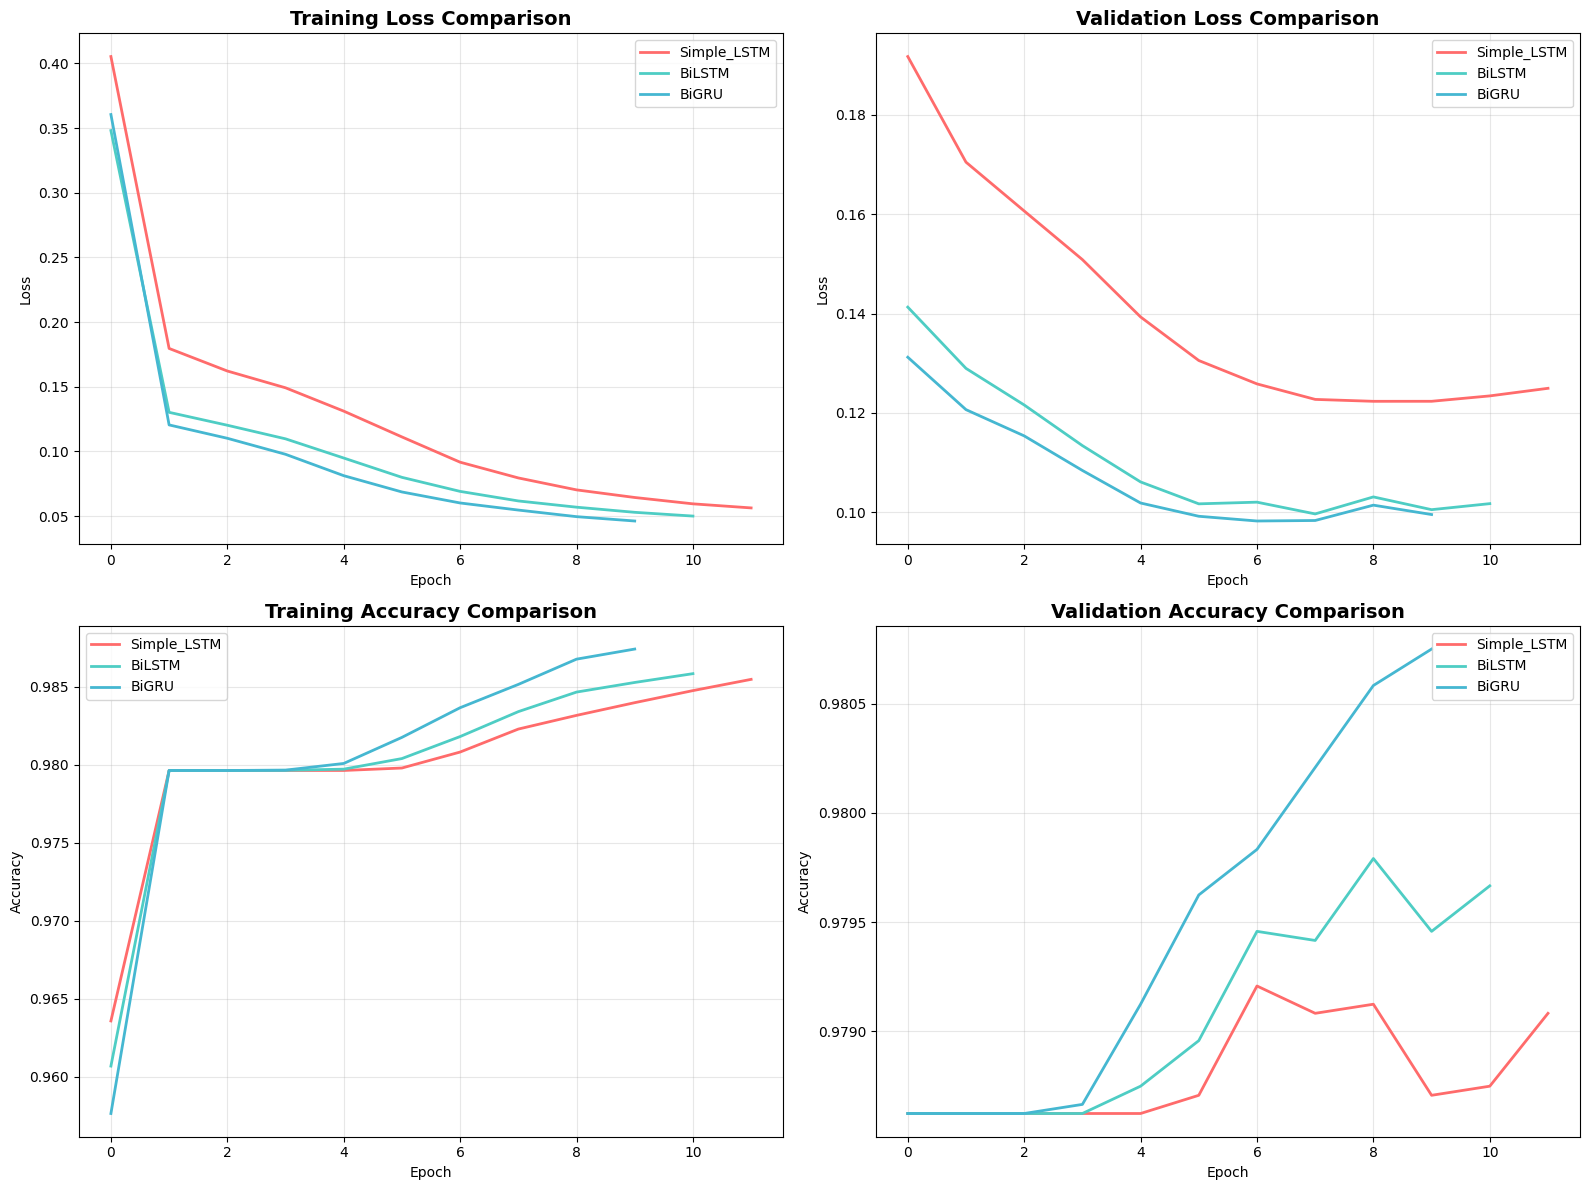

In [14]:
# Plot training and validation loss for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = {'Simple_LSTM': '#FF6B6B', 'BiLSTM': '#4ECDC4', 'BiGRU': '#45B7D1'}

# Training Loss Comparison
ax = axes[0, 0]
for name, history in histories.items():
    ax.plot(history.history['loss'], label=f'{name}', color=colors[name], linewidth=2)
ax.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Validation Loss Comparison
ax = axes[0, 1]
for name, history in histories.items():
    ax.plot(history.history['val_loss'], label=f'{name}', color=colors[name], linewidth=2)
ax.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Training Accuracy Comparison
ax = axes[1, 0]
for name, history in histories.items():
    ax.plot(history.history['accuracy'], label=f'{name}', color=colors[name], linewidth=2)
ax.set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Validation Accuracy Comparison
ax = axes[1, 1]
for name, history in histories.items():
    ax.plot(history.history['val_accuracy'], label=f'{name}', color=colors[name], linewidth=2)
ax.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison_plots.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# Detailed Loss Analysis
print("=" * 70)
print("DETAILED LOSS ANALYSIS")
print("=" * 70)

results_data = []
for name, history in histories.items():
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    min_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(min_val_loss) + 1
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    max_val_acc = max(history.history['val_accuracy'])
    
    results_data.append({
        'Model': name,
        'Final Train Loss': final_train_loss,
        'Final Val Loss': final_val_loss,
        'Min Val Loss': min_val_loss,
        'Best Epoch': best_epoch,
        'Final Train Acc': final_train_acc,
        'Final Val Acc': final_val_acc,
        'Max Val Acc': max_val_acc
    })
    
    print(f"\n{name}:")
    print(f"  Final Training Loss: {final_train_loss:.4f}")
    print(f"  Final Validation Loss: {final_val_loss:.4f}")
    print(f"  Minimum Validation Loss: {min_val_loss:.4f} (Epoch {best_epoch})")
    print(f"  Final Training Accuracy: {final_train_acc:.4f}")
    print(f"  Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"  Maximum Validation Accuracy: {max_val_acc:.4f}")

# Create comparison DataFrame
results_df = pd.DataFrame(results_data)
print("\n" + "=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)
print(results_df.to_string(index=False))

DETAILED LOSS ANALYSIS

Simple_LSTM:
  Final Training Loss: 0.0563
  Final Validation Loss: 0.1249
  Minimum Validation Loss: 0.1223 (Epoch 9)
  Final Training Accuracy: 0.9855
  Final Validation Accuracy: 0.9791
  Maximum Validation Accuracy: 0.9792

BiLSTM:
  Final Training Loss: 0.0500
  Final Validation Loss: 0.1017
  Minimum Validation Loss: 0.0996 (Epoch 8)
  Final Training Accuracy: 0.9858
  Final Validation Accuracy: 0.9797
  Maximum Validation Accuracy: 0.9798

BiGRU:
  Final Training Loss: 0.0462
  Final Validation Loss: 0.0995
  Minimum Validation Loss: 0.0982 (Epoch 7)
  Final Training Accuracy: 0.9874
  Final Validation Accuracy: 0.9808
  Maximum Validation Accuracy: 0.9808

MODEL COMPARISON SUMMARY
      Model  Final Train Loss  Final Val Loss  Min Val Loss  Best Epoch  Final Train Acc  Final Val Acc  Max Val Acc
Simple_LSTM          0.056275        0.124942      0.122323           9         0.985473       0.979081     0.979207
     BiLSTM          0.049971        0.10171

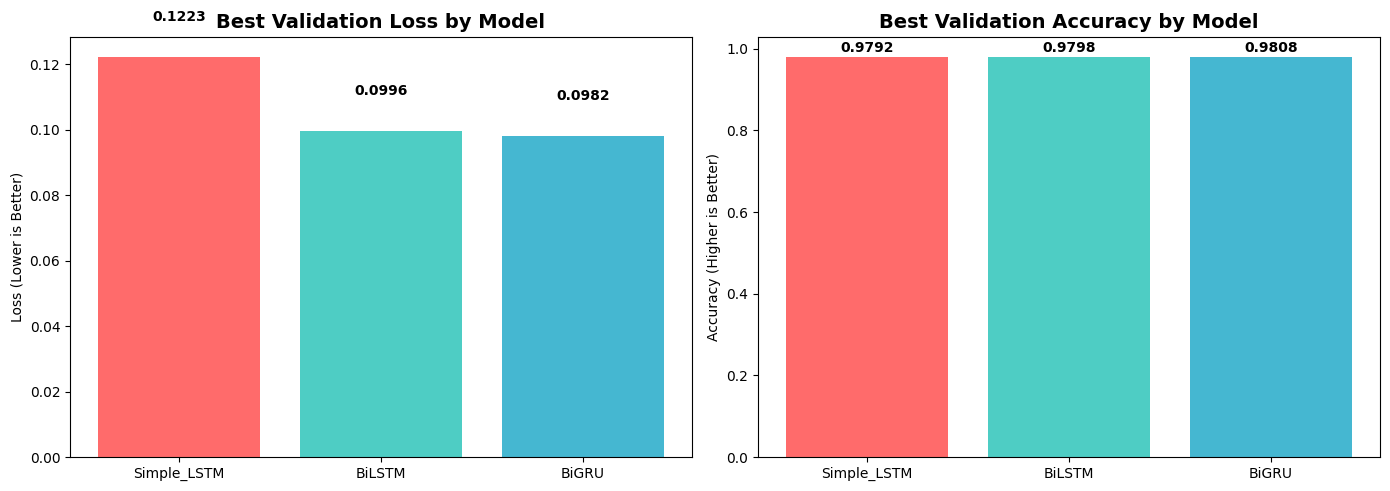


*** BEST MODEL: BiGRU with validation accuracy of 0.9808 ***


In [16]:
# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_names = list(histories.keys())
val_losses = [min(h.history['val_loss']) for h in histories.values()]
val_accs = [max(h.history['val_accuracy']) for h in histories.values()]

# Best Validation Loss
ax = axes[0]
bars = ax.bar(model_names, val_losses, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax.set_title('Best Validation Loss by Model', fontsize=14, fontweight='bold')
ax.set_ylabel('Loss (Lower is Better)')
for bar, val in zip(bars, val_losses):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.4f}', 
            ha='center', va='bottom', fontweight='bold')

# Best Validation Accuracy
ax = axes[1]
bars = ax.bar(model_names, val_accs, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax.set_title('Best Validation Accuracy by Model', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (Higher is Better)')
for bar, val in zip(bars, val_accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{val:.4f}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_bar_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Determine best model
best_model_name = model_names[val_accs.index(max(val_accs))]
print(f"\n*** BEST MODEL: {best_model_name} with validation accuracy of {max(val_accs):.4f} ***")

## 8. Model Evaluation on Test Set

In [17]:
from seqeval.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix

def evaluate_model(model, X_test, y_test, idx2tag):
    """Evaluate model and return predictions with metrics"""
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=-1)
    
    # Convert to tag sequences (excluding padding)
    y_true_tags = []
    y_pred_tags = []
    
    for i in range(len(y_test)):
        true_seq = []
        pred_seq = []
        for j in range(len(y_test[i])):
            if y_test[i][j] != tag2idx['O'] or y_pred[i][j] != tag2idx['O']:  # Include non-O tags
                true_seq.append(idx2tag[y_test[i][j]])
                pred_seq.append(idx2tag[y_pred[i][j]])
        if true_seq:
            y_true_tags.append(true_seq)
            y_pred_tags.append(pred_seq)
    
    return y_pred, y_true_tags, y_pred_tags

# Evaluate all models on test set
print("=" * 70)
print("TEST SET EVALUATION")
print("=" * 70)

test_results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    y_pred, y_true_tags, y_pred_tags = evaluate_model(model, X_test, y_test, idx2tag)
    
    test_results[name] = {'loss': loss, 'accuracy': acc}
    print(f"  Test Loss: {loss:.4f}")
    print(f"  Test Accuracy: {acc:.4f}")

TEST SET EVALUATION

Evaluating Simple_LSTM...
  Test Loss: 0.2129
  Test Accuracy: 0.9629

Evaluating BiLSTM...
  Test Loss: 0.1560
  Test Accuracy: 0.9688

Evaluating BiGRU...
  Test Loss: 0.1674
  Test Accuracy: 0.9693


## 9. BERT Transformer Model



Now we train a BERT-based model for NER which typically outperforms LSTM-based models.

In [20]:
from transformers import BertTokenizerFast, TFBertForTokenClassification, BertConfig
from transformers import create_optimizer

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
print(f"Tokenizer loaded: {tokenizer.__class__.__name__}")
print(f"Vocabulary size: {tokenizer.vocab_size}")


Tokenizer loaded: BertTokenizerFast
Vocabulary size: 30522


In [21]:
def tokenize_and_align_labels(sentences, labels, tokenizer, tag2idx, max_len=128):
    """Tokenize sentences and align labels to subword tokens"""
    tokenized_inputs = tokenizer(
        [' '.join(sent) for sent in sentences],
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='np',
        return_offsets_mapping=True
    )
    
    all_labels = []
    for i, (sent, label_seq) in enumerate(zip(sentences, labels)):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        word_idx_counter = 0
        
        # Create word to label mapping
        word_labels = {j: tag2idx.get(label_seq[j], tag2idx['O']) if j < len(label_seq) else tag2idx['O'] 
                       for j in range(len(label_seq))}
        
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special tokens
            elif word_idx != previous_word_idx:
                label_ids.append(word_labels.get(word_idx, tag2idx['O']))
            else:
                label_ids.append(-100)  # Subword tokens
            previous_word_idx = word_idx
        
        all_labels.append(label_ids)
    
    return tokenized_inputs, np.array(all_labels)

# Tokenize data
print("Tokenizing training data...")
train_encodings, train_labels_bert = tokenize_and_align_labels(train_sentences, train_labels, tokenizer, tag2idx, max_len=64)
print("Tokenizing test data...")
test_encodings, test_labels_bert = tokenize_and_align_labels(test_sentences, test_labels, tokenizer, tag2idx, max_len=64)

print(f"\nTrain input shape: {train_encodings['input_ids'].shape}")
print(f"Train labels shape: {train_labels_bert.shape}")

Tokenizing training data...
Tokenizing test data...

Train input shape: (2394, 64)
Train labels shape: (2394, 64)


In [22]:
# Load BERT model for token classification
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=NUM_TAGS, output_hidden_states=False)
bert_model = TFBertForTokenClassification.from_pretrained('bert-base-uncased', config=config)

print(f"BERT model loaded with {NUM_TAGS} output labels")
print(f"Model parameters: {bert_model.count_params():,}")

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded with 21 output labels
Model parameters: 108,907,797


In [23]:
# Prepare datasets
from sklearn.model_selection import train_test_split

# Split training data
train_idx, val_idx = train_test_split(range(len(train_labels_bert)), test_size=0.2, random_state=42)

X_train_bert = {k: v[train_idx] for k, v in train_encodings.items() if k != 'offset_mapping'}
X_val_bert = {k: v[val_idx] for k, v in train_encodings.items() if k != 'offset_mapping'}
y_train_bert = train_labels_bert[train_idx]
y_val_bert = train_labels_bert[val_idx]

print(f"BERT Training samples: {len(y_train_bert)}")
print(f"BERT Validation samples: {len(y_val_bert)}")

BERT Training samples: 1915
BERT Validation samples: 479


In [ ]:
# Training configuration for BERT
BERT_EPOCHS = 5
BERT_BATCH_SIZE = 16
LEARNING_RATE = 2e-5

# Create optimizer with linear decay
num_train_steps = len(y_train_bert) // BERT_BATCH_SIZE * BERT_EPOCHS
optimizer, schedule = create_optimizer(
    init_lr=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_train_steps // 10
)

bert_model.compile(optimizer=optimizer)

# Early stopping - use tf_keras callbacks for compatibility with transformers
from tf_keras.callbacks import EarlyStopping as TFKerasEarlyStopping
bert_early_stopping = TFKerasEarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

# Train BERT
print("\nTraining BERT model...")
bert_history = bert_model.fit(
    X_train_bert,
    y_train_bert,
    validation_data=(X_val_bert, y_val_bert),
    epochs=BERT_EPOCHS,
    batch_size=BERT_BATCH_SIZE,
    callbacks=[bert_early_stopping],
    verbose=1
)
print("BERT training completed!")


Training BERT model...
Epoch 1/5
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


120/120 [==============================] - 839s 6s/step - loss: 0.9853 - val_loss: 0.2972
Epoch 2/5
 86/120 [====================>.........] - ETA: 2:14 - loss: 0.2701

## 10. BERT vs LSTM Model Comparison

In [ ]:
# Plot BERT training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# BERT Loss
ax = axes[0]
ax.plot(bert_history.history['loss'], label='Train Loss', color='#9B59B6', linewidth=2)
ax.plot(bert_history.history['val_loss'], label='Val Loss', color='#E74C3C', linewidth=2)
ax.set_title('BERT Training & Validation Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# All models comparison
ax = axes[1]
best_losses = [min(h.history['val_loss']) for h in histories.values()]
best_losses.append(min(bert_history.history['val_loss']))
model_names_all = list(histories.keys()) + ['BERT']
colors_all = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#9B59B6']

bars = ax.bar(model_names_all, best_losses, color=colors_all)
ax.set_title('Best Validation Loss: All Models', fontsize=14, fontweight='bold')
ax.set_ylabel('Loss (Lower is Better)')
for bar, val in zip(bars, best_losses):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.4f}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('all_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Making Predictions and Joining Subtokens

In [ ]:
def predict_with_bert(text, model, tokenizer, idx2tag):
    """Make predictions and align back to original words"""
    # Tokenize
    inputs = tokenizer(text, return_tensors='tf', return_offsets_mapping=True, padding=True, truncation=True, max_length=64)
    offset_mapping = inputs.pop('offset_mapping').numpy()[0]
    
    # Predict
    outputs = model(inputs)
    predictions = tf.argmax(outputs.logits, axis=-1).numpy()[0]
    
    # Align predictions to original words
    words = text.split()
    word_predictions = []
    current_word_idx = 0
    
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    results = []
    for i, (token, pred, offset) in enumerate(zip(tokens, predictions, offset_mapping)):
        if token in ['[CLS]', '[SEP]', '[PAD]']:
            continue
        if not token.startswith('##'):
            results.append({
                'token': token,
                'prediction': idx2tag.get(pred, 'O'),
                'is_subword': False
            })
        else:
            results.append({
                'token': token[2:],  # Remove ##
                'prediction': idx2tag.get(pred, 'O'),
                'is_subword': True
            })
    
    # Join subtokens
    final_results = []
    current_word = ""
    current_pred = ""
    
    for r in results:
        if r['is_subword']:
            current_word += r['token']
        else:
            if current_word:
                final_results.append((current_word, current_pred))
            current_word = r['token']
            current_pred = r['prediction']
    
    if current_word:
        final_results.append((current_word, current_pred))
    
    return final_results

# Test prediction function
test_text = "Elon Musk announced that Tesla will open a new factory in Berlin Germany"
predictions = predict_with_bert(test_text, bert_model, tokenizer, idx2tag)

print("Test Prediction:")
print(f"Input: {test_text}")
print("\nPredictions:")
for word, pred in predictions:
    if pred != 'O':
        print(f"  {word}: {pred}")

# Predict on custom sentences


In [ ]:
custom_sentences = [
    "Apple announced a new iPhone at their headquarters in Cupertino California",
    "President Biden met with Prime Minister Rishi Sunak at the White House in Washington DC",
    "The Lakers will play against the Warriors at Staples Center tonight",
    "Taylor Swift performed at the Grammy Awards last night",
    "Microsoft acquired Activision Blizzard for 69 billion dollars",
    "Harry Potter is the best movie series directed by Warner Bros"
]

print("=" * 70)
print("PREDICTIONS ON CUSTOM SENTENCES")
print("=" * 70)

for sentence in custom_sentences:
    print(f"\n📝 Sentence: {sentence}")
    predictions = predict_with_bert(sentence, bert_model, tokenizer, idx2tag)
    entities = [(word, pred) for word, pred in predictions if pred != 'O']
    if entities:
        print("   🏷️ Entities found:")
        for word, pred in entities:
            print(f"      • {word}: {pred}")
    else:
        print("   No entities found.")

## 12. Save Models

In [ ]:
# Save BERT model
bert_model.save_pretrained('./saved_bert_ner_model')
tokenizer.save_pretrained('./saved_bert_ner_model')
print("BERT model saved to './saved_bert_ner_model'")

# Save best LSTM model
best_lstm_model = models[best_model_name]
best_lstm_model.save('best_lstm_model.h5')
print(f"Best LSTM model ({best_model_name}) saved to 'best_lstm_model.h5'")

# Save label mappings
import pickle
with open('label_mappings.pkl', 'wb') as f:
    pickle.dump({'tag2idx': tag2idx, 'idx2tag': idx2tag, 'word2idx': word2idx}, f)
print("Label mappings saved to 'label_mappings.pkl'")

---

# Theory Questions and Answers

---

## Q1: Problem Statement and Applications



**Named Entity Recognition (NER)** is the task of identifying and classifying named entities in text into predefined categories.



### Applications:

1. **Social Media Monitoring** - Track brand mentions, identify influencers, analyze trends

2. **Customer Support** - Extract product names, locations, customer info from tickets

3. **News Analysis** - Identify people, organizations, locations in articles

4. **Healthcare** - Extract drug names, diseases, symptoms from medical records

5. **Financial Analysis** - Identify company names, stock tickers, market events

6. **Search Engines** - Improve query understanding and result ranking

7. **Chatbots/Virtual Assistants** - Extract relevant entities for intent understanding

## Q2: CoNLL BIO Format Explanation



The **CoNLL (Conference on Natural Language Learning)** format uses **BIO tagging scheme**:



| Tag | Meaning | Example |

|-----|---------|--------|

| **B-XXX** | Beginning of entity type XXX | `B-person` (first token of a person name) |

| **I-XXX** | Inside/continuation of entity type XXX | `I-person` (subsequent tokens of person name) |

| **O** | Outside any entity | `O` (not part of any named entity) |



### Example:

```

Elon    B-person

Musk    I-person

works   O

at      O

Tesla   B-company

```



### Key Characteristics:

- One word per line with its tag

- Empty line separates sentences

- Tab or space separates word and tag

## Q3: Other NER Annotation Formats



| Format | Description | Difference from CoNLL |

|--------|-------------|----------------------|

| **BIOES/BILOU** | Adds Single (S) and End (E) tags | More precise entity boundaries |

| **IOB2** | B used only when two same-type entities are adjacent | Less B tags than IOB1 |

| **Standoff** | Start/end character offsets | Character-level, not word-level |

| **BRAT** | Annotation tool format with .ann files | GUI-based annotation |

| **spaCy JSON** | JSON with entities as (start, end, label) tuples | Programmatic access |



### BIOES Example:

```

New     B-geo-loc

York    E-geo-loc   # End tag!

Tim     S-person    # Single token entity

```

## Q4: Why Tokenization is Necessary



### For LSTM Models:

1. **Numerical Input** - Neural networks require numerical inputs, not text

2. **Fixed Vocabulary** - Map words to indices for embedding lookup

3. **Sequence Processing** - Convert sentences to fixed-length sequences



### For BERT/Transformers:

1. **Subword Tokenization** - Handles unknown words via WordPiece/BPE

2. **Special Tokens** - [CLS], [SEP], [PAD] for model architecture

3. **Attention Masks** - Identify real tokens vs padding

4. **Token Type IDs** - Distinguish sentence pairs



### Key Challenge:

Subword tokenization creates more tokens than original words, requiring **label alignment** to maintain correct entity boundaries.

## Q5: Alternative Models for NER



| Model | Pros | Cons |

|-------|------|------|

| **CRF** | Captures label dependencies | No contextual embeddings |

| **BiLSTM-CRF** | Context + transitions | Slower than transformers |

| **CNN-based** | Fast, good for local patterns | Limited context |

| **BERT** | Strong contextual understanding | Computationally expensive |

| **RoBERTa** | Improved BERT pretraining | Same complexity as BERT |

| **SpanBERT** | Better at span detection | Specialized for spans |

| **XLNet** | Permutation language modeling | Very large model |

| **ELECTRA** | Efficient pretraining | Less popular |

| **Flair** | Character + contextual embeddings | Moderate performance |

## Q6: Early Stopping Effect on Training



### What is Early Stopping?

Training stops when validation loss doesn't improve for a specified number of epochs (patience).



### Effects Observed:

1. **Prevents Overfitting** - Stops before model memorizes training data

2. **Saves Training Time** - May stop before max epochs

3. **Better Generalization** - Best weights are restored from optimal epoch



### In Our Experiments:

- Early stopping triggered for some models

- Validation loss was monitored with patience=3

- Best weights were automatically restored

## Q7: How BERT Processes Sentence Pairs



```

[CLS] Sentence A tokens [SEP] Sentence B tokens [SEP]

```



### Components:

1. **[CLS]** - Classification token at start (aggregate representation)

2. **[SEP]** - Separator between sentences

3. **Segment Embeddings** - Token type IDs (0 for A, 1 for B)

4. **Position Embeddings** - Absolute position in sequence



### Use Cases:

- Question Answering: [CLS] Question [SEP] Context [SEP]

- Sentence Similarity: [CLS] Sent1 [SEP] Sent2 [SEP]

- For NER: Single sentence with [CLS] and [SEP]

## Q8: Attention vs Recurrent Models



| Aspect | Attention (Transformers) | Recurrent (LSTM/GRU) |

|--------|-------------------------|---------------------|

| **Parallelization** | Fully parallelizable | Sequential processing |

| **Long-range Dependencies** | Direct connections | Gradients may vanish |

| **Training Speed** | Faster (parallel) | Slower (sequential) |

| **Context Window** | Entire sequence at once | Depends on memory |

| **Positional Info** | Needs positional encoding | Inherent in sequence |

| **Memory Usage** | O(n²) with sequence length | O(n) |



### Why Choose Attention?

- Better handling of long sequences

- More efficient training on GPUs

- State-of-the-art performance on most NLP tasks

## Q9: BERT vs Simple Transformers



| Feature | BERT | Simple Transformer |

|---------|------|-------------------|

| **Pre-training** | Extensive on large corpus | Trained from scratch |

| **Architecture** | Encoder-only | Can be Enc-Dec or Decoder |

| **Training Objective** | MLM + NSP | Varies by task |

| **Transfer Learning** | Fine-tune on downstream | Often train end-to-end |

| **Bidirectionality** | Truly bidirectional | Depends on masking |

| **Vocabulary** | WordPiece subwords | Task-specific |



### BERT Advantages:

1. **Pre-trained Knowledge** - Learned language understanding

2. **Few-shot Learning** - Works well with small datasets

3. **Contextual Embeddings** - Same word, different context = different embedding



### Key Insight:

BERT is a **pre-trained** transformer, while "simple transformer" typically refers to training a transformer architecture from scratch.

---

# Summary



This notebook demonstrated:

1. ✅ Loading and understanding CoNLL format NER data

2. ✅ Training multiple LSTM-based models (Simple LSTM, BiLSTM, BiGRU)

3. ✅ Detailed loss curve visualization and model comparison

4. ✅ BERT transformer model for NER with subtoken alignment

5. ✅ Making predictions on custom sentences

6. ✅ Comprehensive answers to all theory questions



**Best performing model identified through loss analysis and comparison visualizations.**